# Projeto: Financial_Fraud_Detection

## Importações

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys

import pandas as pd
import numpy as np

import plotly.graph_objs as go
import plotly.express as px

from plotly.subplots import make_subplots
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from datetime import datetime, date
import json
from sklearn import feature_selection
import joblib

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import make_pipeline

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

from pandas import Series
import re
import traceback
import string
from scipy import stats
import numpy as np
import pandas.core.algorithms as algos
import plotly.express as px
#from pandas import quantile

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import shap 

from boruta import BorutaPy
import jupyterthemes as jt 
from jupyterthemes import jtplot  
jtplot.style(theme='oceans16')

### Funções Auxiliares

In [2]:
def distribuicao_2(dataframe, variavel, same_scale = True):
    data_wide = dataframe.pivot(columns='target',
                         values=variavel)
    if same_scale == False:
        data_wide[0] = np.log(1 + data_wide[0])
        data_wide[1] = np.log(1 + data_wide[1])
    else:
        pass
        
    data_wide.plot.density(figsize = (15, 7),
                           linewidth = 2)
    if same_scale == False:
        plt.xlabel(variavel+' (em escala logaritimca)')
    else:
        plt.xlabel(variavel)
    lista1 = dataframe.groupby('target')[variavel].describe().round(2).values.tolist()
    lista2 = [list(dataframe.groupby('target')[variavel].describe().round(2).transpose().index)]
    lista3 = [['Não Target', 'Target']] + lista2 + lista1

    #statistics = print(dataframe.groupby('target')[variavel].describe().round(2).transpose().to_string(justify='right'))
    plt.figtext(0.73,0.73, '  '.join(map(str,lista3[0])), {'multialignment':'right'}, fontsize = 12)
    plt.figtext(0.729,0.73, '___________________', {'multialignment':'right'}, fontsize = 12)
    plt.figtext(0.67,0.48, '\n'.join(map(str, lista3[1])), {'multialignment':'left'}, fontsize = 12)
    plt.figtext(0.75,0.48, '\n'.join(map(str,lista3[2])) , {'multialignment':'right'}, fontsize = 12)
    plt.figtext(0.83,0.48, '\n'.join(map(str,lista3[3])) , {'multialignment':'right'}, fontsize = 12)
    plt.show()

## Descobrindo os Dados

In [3]:
pd.set_option('display.max_columns',None)

### Importando os Dados

In [4]:
df = pd.read_csv('data/fraud_detection.csv')

In [5]:
df = df.apply(lambda x: round(x, 2))

In [6]:
df.sample(5)

target   feat_01   feat_02    feat_03   feat_04  feat_05  feat_06  \
636      0.0      9.40      9.40       9.40      0.00      0.0      1.0   
1093     0.0   4583.25    394.83   78570.39    625.68    113.0    199.0   
1066     0.0   3492.36    614.33   24573.17    743.73     31.0     40.0   
279      0.0    319.86    319.86     319.86      0.00      0.0      1.0   
138      1.0  82142.77  11769.50  411932.36  17514.33      0.0     35.0   

      feat_07  feat_08  feat_09  feat_10  feat_11  feat_12  feat_13  feat_14  \
636       0.0     0.00      0.0      0.0      1.0     0.00      0.0      0.0   
1093      0.0     0.57      0.0     53.0    199.0     0.27      6.0     45.0   
1066      0.0     0.78      0.0     20.0     40.0     0.50     12.0      0.0   
279       0.0     0.00      0.0      0.0      1.0     0.00      0.0      0.0   
138       0.0     0.00      0.0     32.0     35.0     0.91     13.0     35.0   

      feat_15  feat_16  feat_17  feat_18  
636       1.0     0.00     0.00     0.00  
1093    199.0     0.23     0.00   212.88  
1066     40.0     0.00     0.00   104.02  
279       1.0     0.00     0.00     0.00  
138      35.0     1.00     0.29   213.04

In [7]:
df.shape

(1148, 19)

### Filtragem dos Dados

In [8]:
print(df.target.value_counts())
print("\nTargets representam {:.2f}% do dataset.\n".format((df[df.target == 1].shape[0] / df.shape[0]) * 100))

0.0    992
1.0    156
Name: target, dtype: int64

Targets representam 13.59% do dataset.



In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   target   1148 non-null   float64
 1   feat_01  1148 non-null   float64
 2   feat_02  1148 non-null   float64
 3   feat_03  1148 non-null   float64
 4   feat_04  1148 non-null   float64
 5   feat_05  1148 non-null   float64
 6   feat_06  1148 non-null   float64
 7   feat_07  1148 non-null   float64
 8   feat_08  1148 non-null   float64
 9   feat_09  1148 non-null   float64
 10  feat_10  1148 non-null   float64
 11  feat_11  1148 non-null   float64
 12  feat_12  1148 non-null   float64
 13  feat_13  1148 non-null   float64
 14  feat_14  1148 non-null   float64
 15  feat_15  1148 non-null   float64
 16  feat_16  1148 non-null   float64
 17  feat_17  1148 non-null   float64
 18  feat_18  1148 non-null   float64
dtypes: float64(19)
memory usage: 170.5 KB


### Atributos Numéricos

In [10]:
num_attributes = df.select_dtypes(include=['int64','float64','int32'])

In [11]:
# Tendencia Central - media, mediana (Representando o Dataset inteiro)
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x:x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T
# Concatenar
m = pd.concat([d2,d3,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns=['Atributos','Min','Max','Mean','Median','std','skew','kurtosis']
m

Atributos  Min          Max           Mean   Median            std  \
0     target  0.0         1.00       0.135889     0.00       0.342670   
1    feat_01  0.0   7500000.00   31601.791280   449.95  242616.512971   
2    feat_02  0.0    345123.17    4788.514103   219.35   17268.605702   
3    feat_03  0.0  12187323.86  145915.987796  1579.64  764790.326902   
4    feat_04  0.0    916037.12    7368.337291    75.59   38196.089178   
5    feat_05  0.0     18446.00      52.078397     1.00     697.549774   
6    feat_06  0.0     21385.00      98.090592     5.00     877.499535   
7    feat_07  0.0      3566.00       8.531359     0.00     132.222485   
8    feat_08  0.0         1.00       0.314155     0.15       0.357320   
9    feat_09  0.0         1.00       0.103659     0.00       0.304817   
10   feat_10  0.0     20214.00      70.007840     2.00     826.441940   
11   feat_11  0.0     21385.00      97.993031     5.00     877.290024   
12   feat_12  0.0         1.00       0.410897     0.33       0.400685   
13   feat_13  0.0        15.00       3.326655     1.00       4.274805   
14   feat_14  0.0      2721.00       6.753484     0.00      88.143538   
15   feat_15  0.0     21385.00     113.913763     6.00     953.433643   
16   feat_16  0.0         1.00       0.227770     0.00       0.409115   
17   feat_17  0.0         1.00       0.085226     0.00       0.237744   
18   feat_18  0.0      1226.48      67.766516     4.63     137.821001   

         skew    kurtosis  
0    2.127924    2.532471  
1   26.006922  785.096410  
2    9.401784  143.371801  
3   11.584746  156.282251  
4   15.301930  316.628393  
5   23.042663  559.186778  
6   19.605069  431.829122  
7   22.645224  553.973027  
8    0.816061   -0.759322  
9    2.603924    4.788759  
10  20.908815  470.047969  
11  19.614978  432.215948  
12   0.271882   -1.587940  
13   1.175823    0.098664  
14  27.619733  812.656610  
15  17.023326  333.841811  
16   1.312811   -0.223679  
17   2.836930    6.932618  
18   3.375478   14.907522

In [12]:
df1 = df.copy()

## Análise Exploratória dos Dados

### Análise Univariada

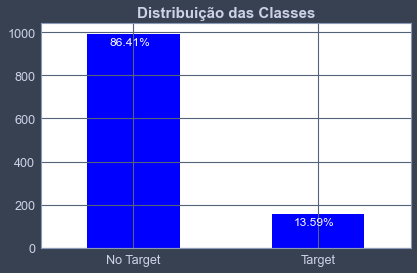

In [13]:
fig, ax = plt.subplots(figsize = (6,4))
ax = df1.target.value_counts().plot(kind = 'bar', color = 'blue')
ax.set_title('Distribuição das Classes', fontsize = 15, loc ='center', weight = 'bold')
ax.set_xticklabels(['No Target' , 'Target'], rotation = 0)
ax.patch.set_facecolor('white')

total = []

for i in ax.patches:
    total.append(i.get_height())

soma = sum(total)

for i in ax.patches:
    ax.text(i.get_x() + .12, i.get_height() - 50,
            str(round((i.get_height()/soma)*100, 2)) + '%',
            fontsize = 12, color = 'white')#, weight = 'bold')
    
plt.tight_layout()

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   target   1148 non-null   float64
 1   feat_01  1148 non-null   float64
 2   feat_02  1148 non-null   float64
 3   feat_03  1148 non-null   float64
 4   feat_04  1148 non-null   float64
 5   feat_05  1148 non-null   float64
 6   feat_06  1148 non-null   float64
 7   feat_07  1148 non-null   float64
 8   feat_08  1148 non-null   float64
 9   feat_09  1148 non-null   float64
 10  feat_10  1148 non-null   float64
 11  feat_11  1148 non-null   float64
 12  feat_12  1148 non-null   float64
 13  feat_13  1148 non-null   float64
 14  feat_14  1148 non-null   float64
 15  feat_15  1148 non-null   float64
 16  feat_16  1148 non-null   float64
 17  feat_17  1148 non-null   float64
 18  feat_18  1148 non-null   float64
dtypes: float64(19)
memory usage: 170.5 KB


In [14]:
# Verificar valores ausentes
df1.fillna(df1.mean(), inplace=True)

In [15]:
print(df1.dtypes)

target     float64
feat_01    float64
feat_02    float64
feat_03    float64
feat_04    float64
feat_05    float64
feat_06    float64
feat_07    float64
feat_08    float64
feat_09    float64
feat_10    float64
feat_11    float64
feat_12    float64
feat_13    float64
feat_14    float64
feat_15    float64
feat_16    float64
feat_17    float64
feat_18    float64
dtype: object


### Análise Bi-Variada

A continuação avaliaremos cada uma das variáveis em função da variável alvo.

In [16]:
# Removendo company com max_valor_boleto Outlier de 7500000
filtro = df1['feat_01'] < 3500000
df1 = df1[filtro]

In [17]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1147 entries, 0 to 1147
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   target   1147 non-null   float64
 1   feat_01  1147 non-null   float64
 2   feat_02  1147 non-null   float64
 3   feat_03  1147 non-null   float64
 4   feat_04  1147 non-null   float64
 5   feat_05  1147 non-null   float64
 6   feat_06  1147 non-null   float64
 7   feat_07  1147 non-null   float64
 8   feat_08  1147 non-null   float64
 9   feat_09  1147 non-null   float64
 10  feat_10  1147 non-null   float64
 11  feat_11  1147 non-null   float64
 12  feat_12  1147 non-null   float64
 13  feat_13  1147 non-null   float64
 14  feat_14  1147 non-null   float64
 15  feat_15  1147 non-null   float64
 16  feat_16  1147 non-null   float64
 17  feat_17  1147 non-null   float64
 18  feat_18  1147 non-null   float64
dtypes: float64(19)
memory usage: 179.2 KB


#### feat_01 x Target

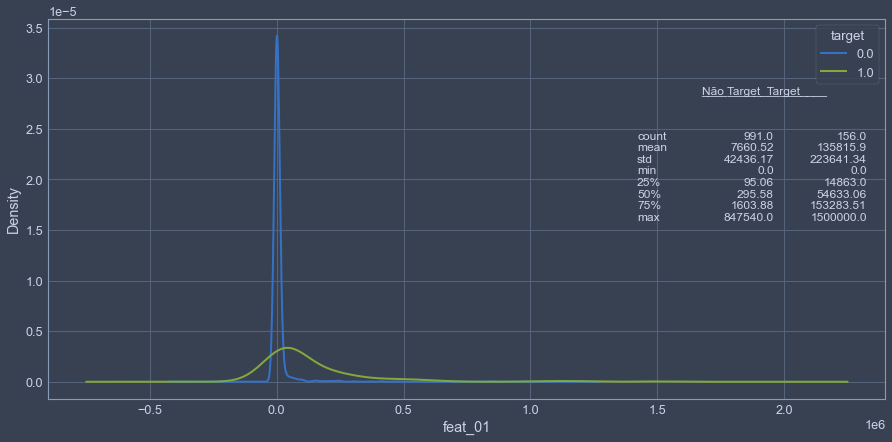

None

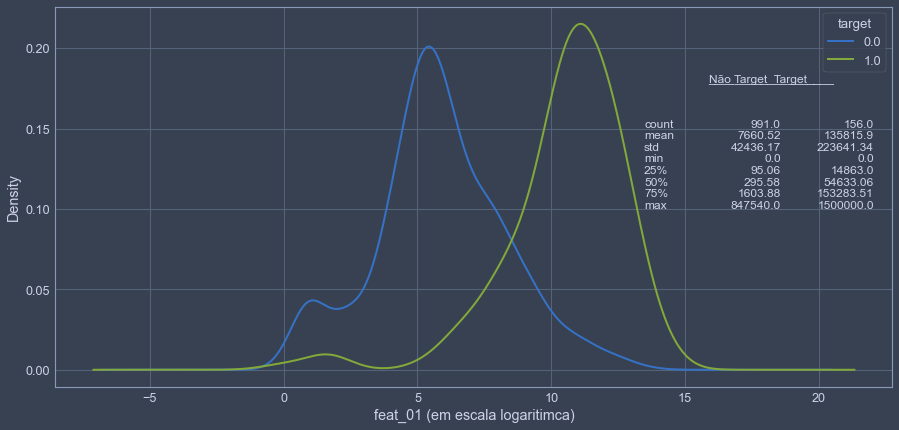

None

In [20]:
display(distribuicao_2(df1, 'feat_01', 1))
display(distribuicao_2(df1, 'feat_01', 0))

In [21]:
# Boxplot
px.box(df1, y='feat_01', x='target' , points='all' )

#### feat_02 x target

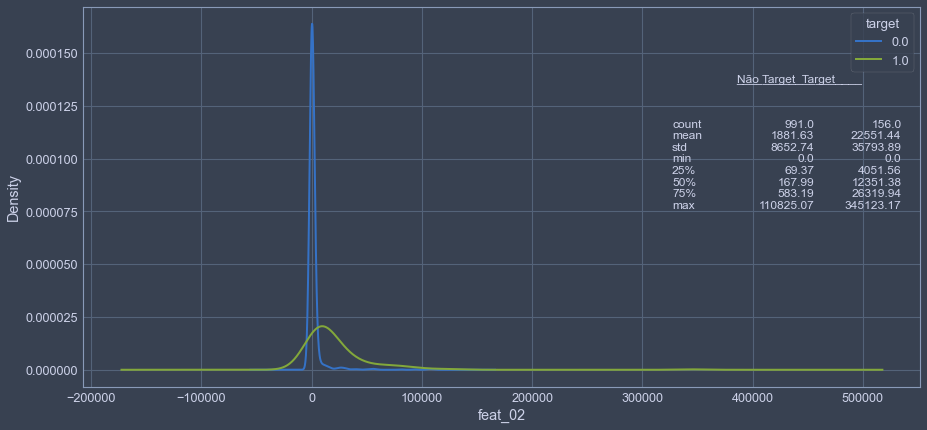

None

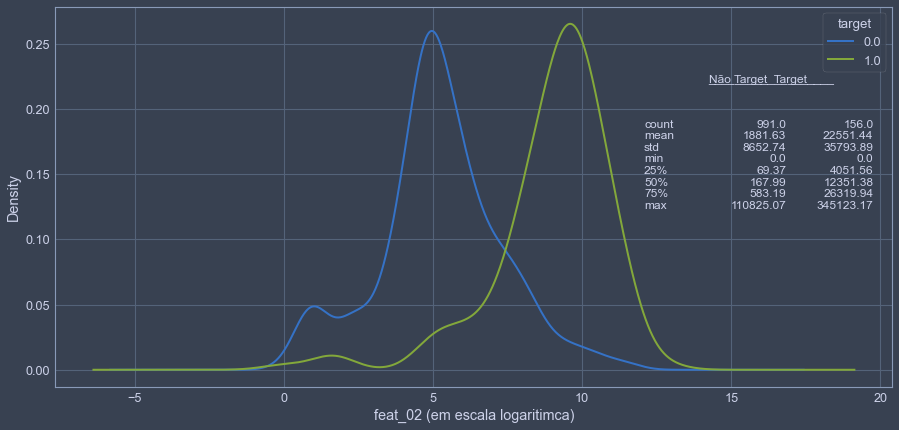

None

In [22]:
display(distribuicao_2(df1, 'feat_02', 1))
display(distribuicao_2(df1, 'feat_02', 0))

In [23]:
# Boxplot
px.box(df1, y='feat_02', x='target' , points='all' )

#### feat_03 x target

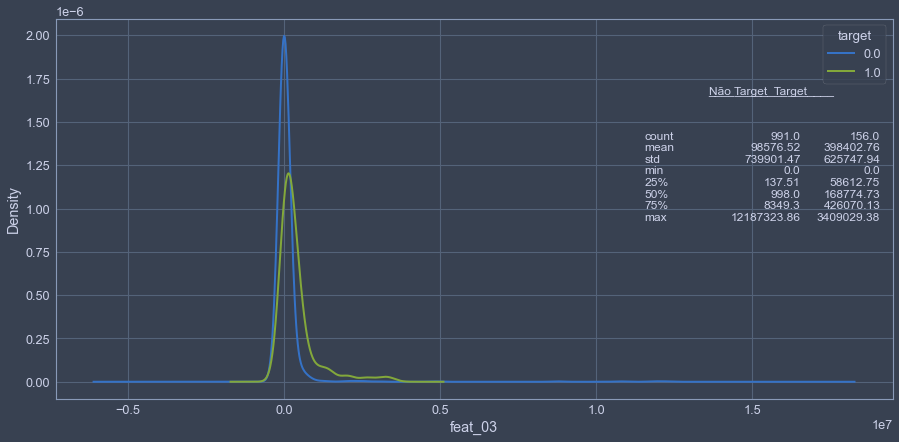

None

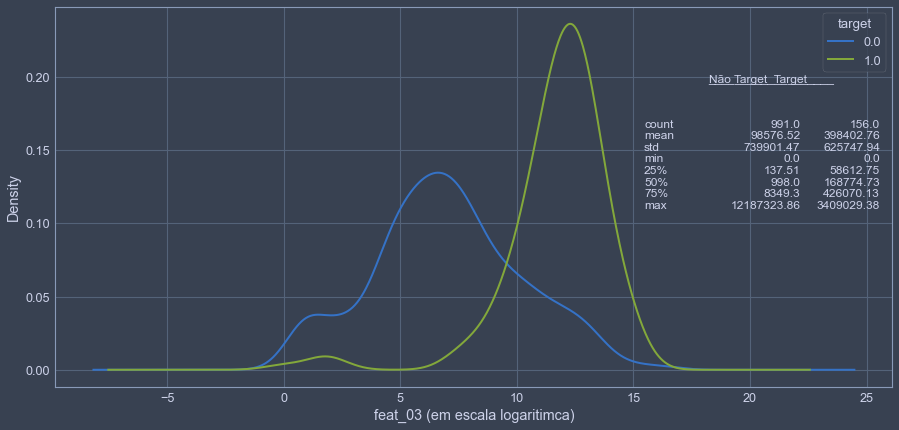

None

In [24]:
display(distribuicao_2(df1, 'feat_03', 1))
display(distribuicao_2(df1, 'feat_03', 0))

In [25]:
# Boxplot
px.box(df1, y='feat_03', x='target' , points='all' )

#### feat_04 x target

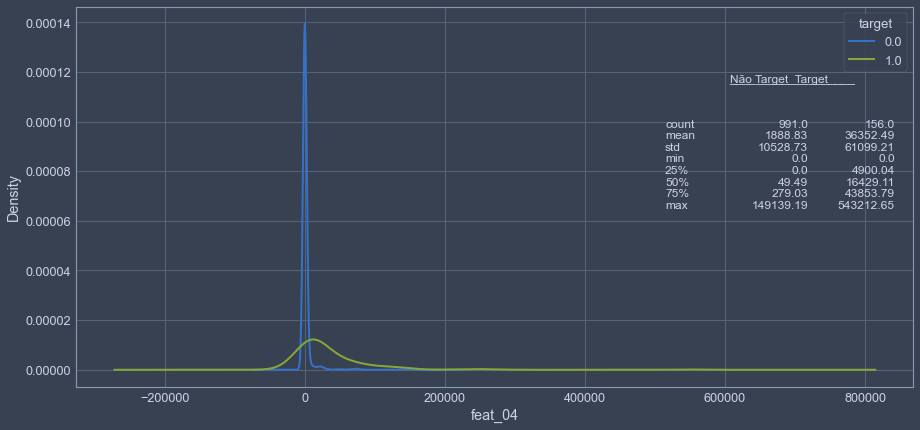

None

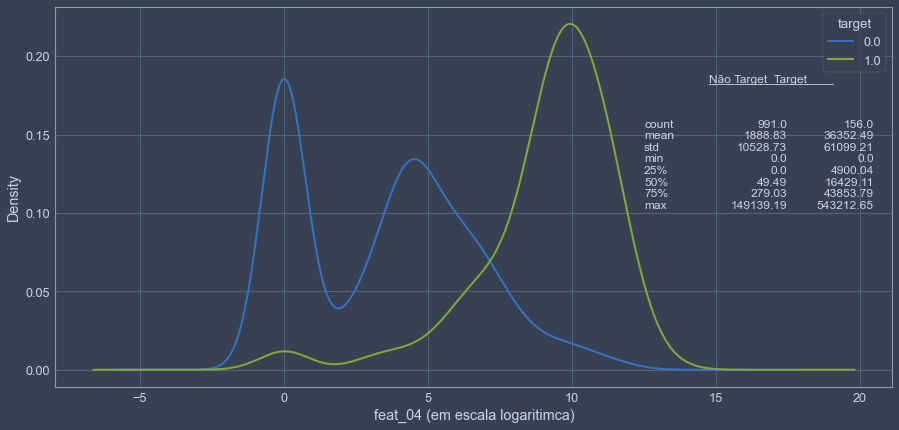

None

In [26]:
display(distribuicao_2(df1, 'feat_04', 1))
display(distribuicao_2(df1, 'feat_04', 0))

In [27]:
# Boxplot
px.box(df1, y='feat_04', x='target' , points='all' )

#### feat_05 x target

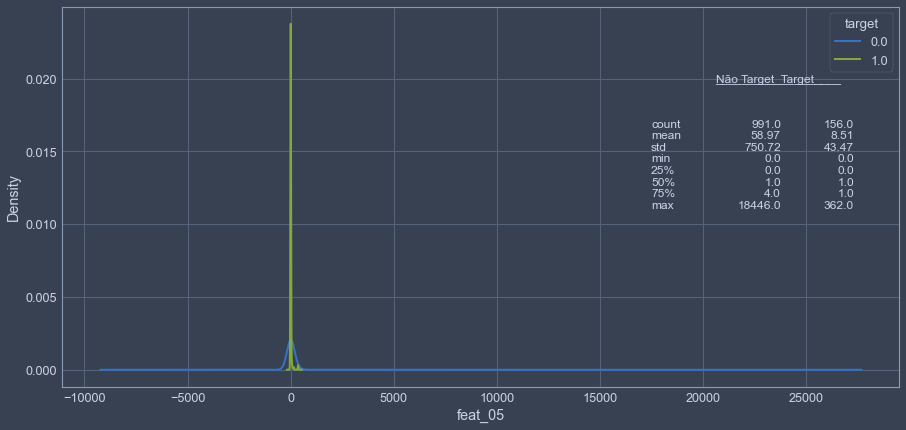

None

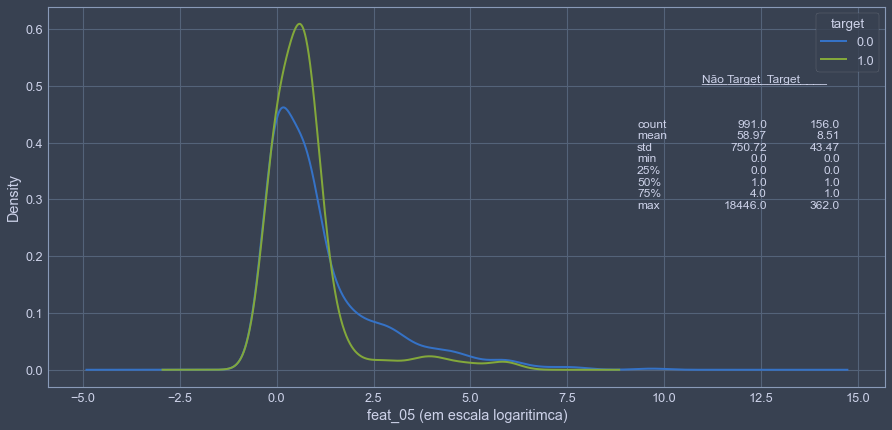

None

In [28]:
display(distribuicao_2(df1, 'feat_05', 1))
display(distribuicao_2(df1, 'feat_05', 0))

In [29]:
# Boxplot
px.box(df1, y='feat_05', x='target' , points='all' )

#### feat_06 x target

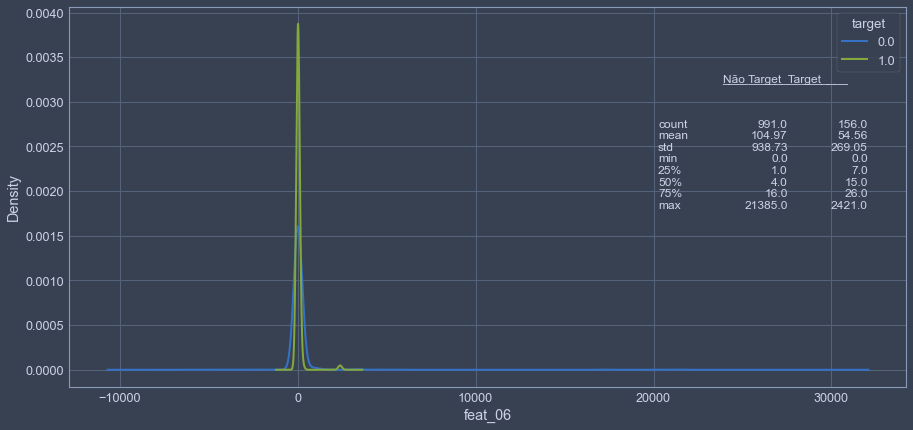

None

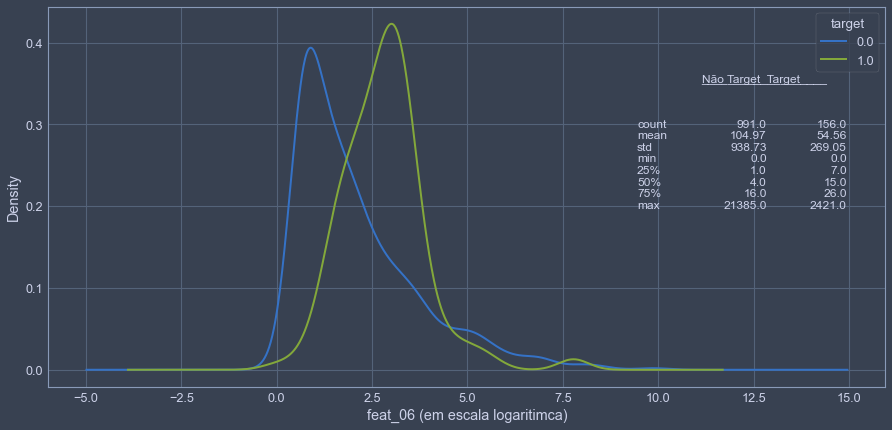

None

In [30]:
display(distribuicao_2(df1, 'feat_06', 1))
display(distribuicao_2(df1, 'feat_06', 0))

#### feat_07 x target

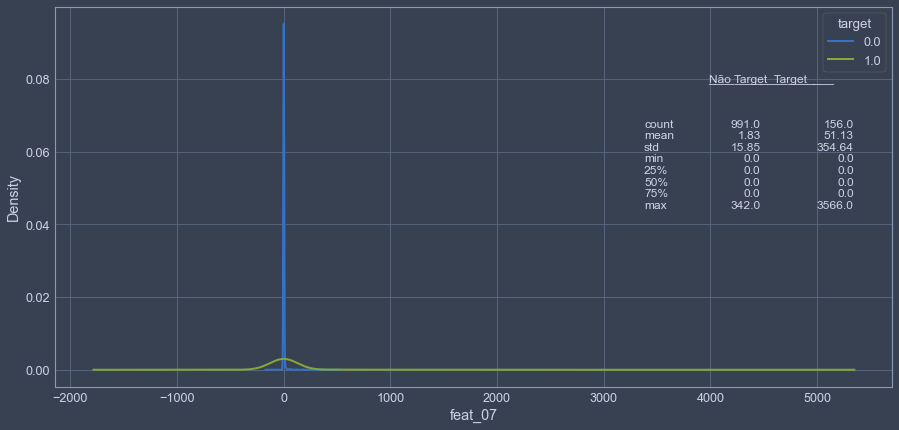

None

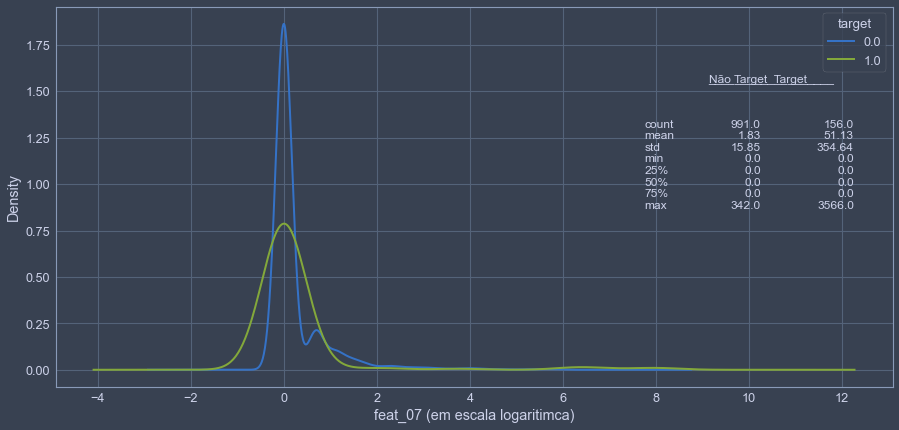

None

In [31]:
display(distribuicao_2(df1, 'feat_07', 1))
display(distribuicao_2(df1, 'feat_07', 0))

#### feat_08 x target

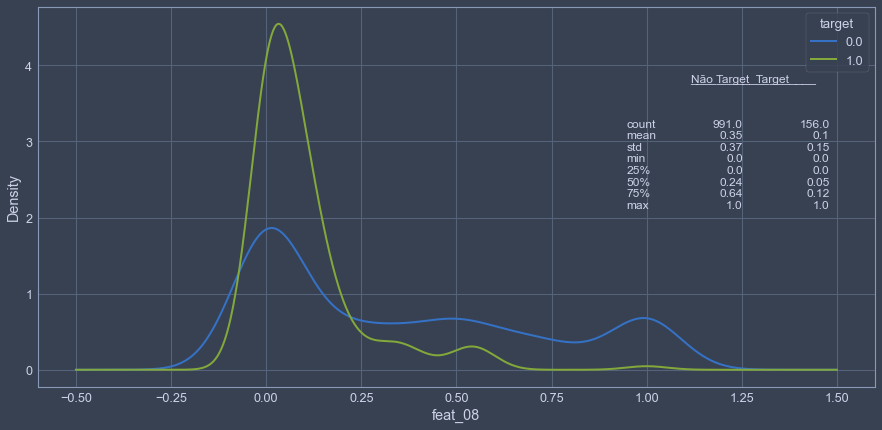

None

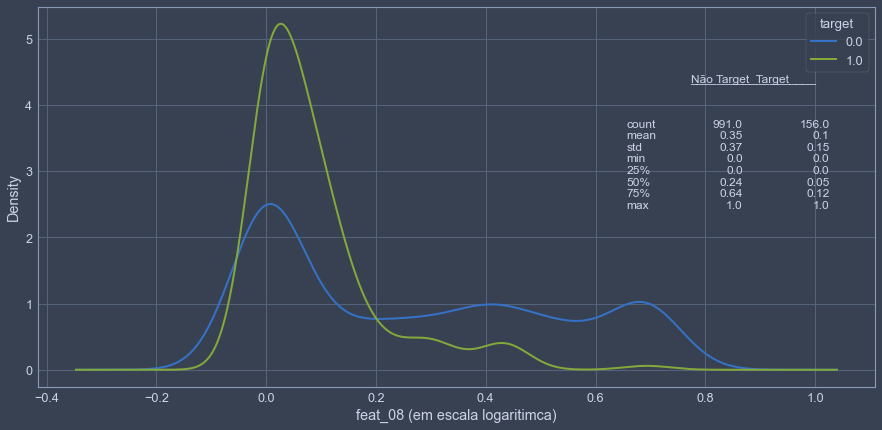

None

In [32]:
display(distribuicao_2(df1, 'feat_08', 1))
display(distribuicao_2(df1, 'feat_08', 0))

#### feat_09 x target

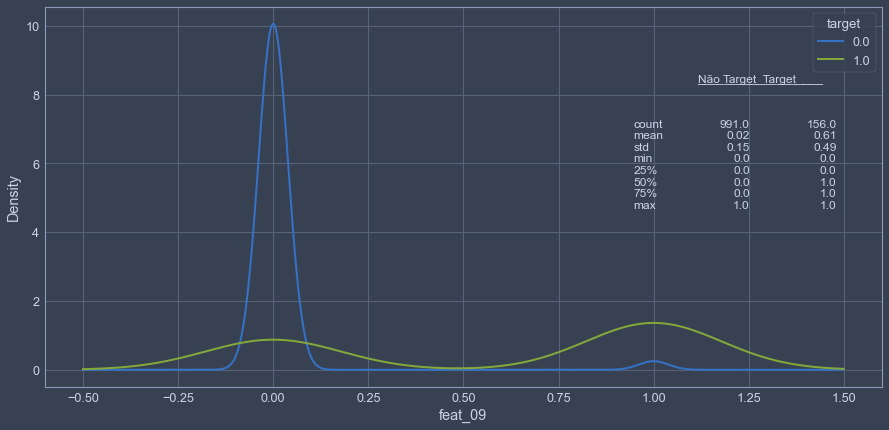

None

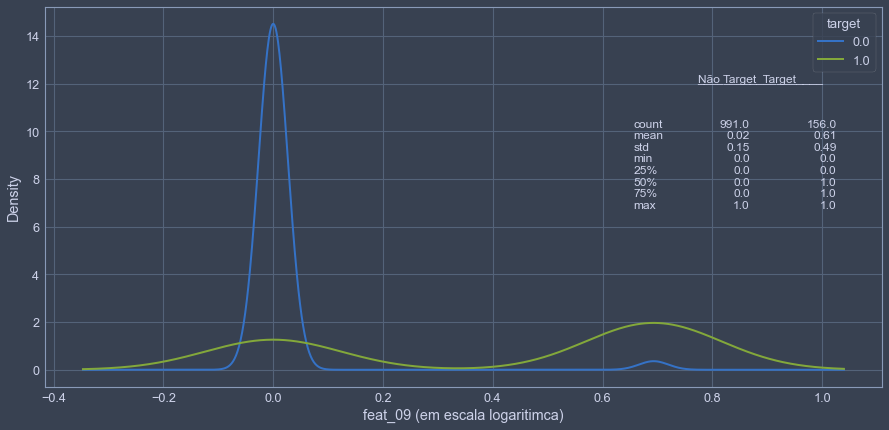

None

In [33]:
display(distribuicao_2(df1, 'feat_09', 1))
display(distribuicao_2(df1, 'feat_09', 0))

#### feat_10 x target

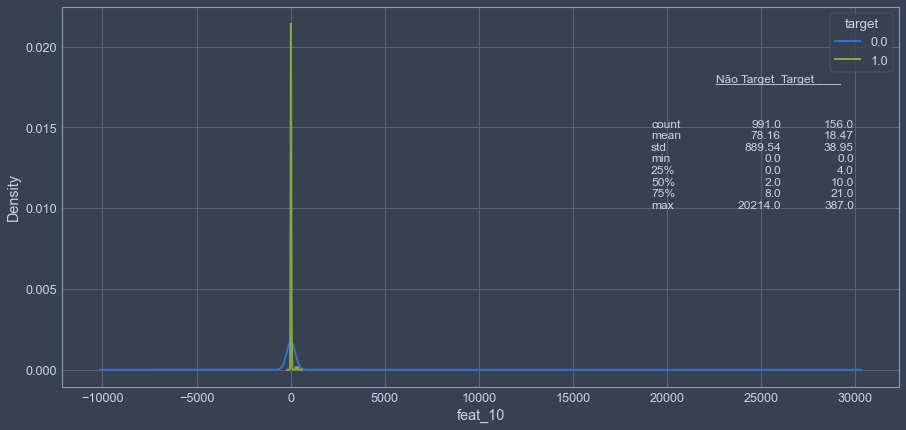

None

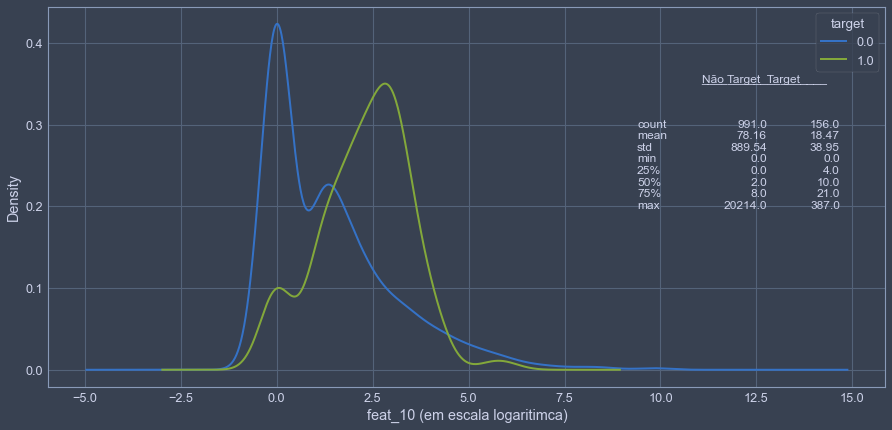

None

In [34]:
display(distribuicao_2(df1, 'feat_10', 1))
display(distribuicao_2(df1, 'feat_10', 0))

#### feat_11 x target

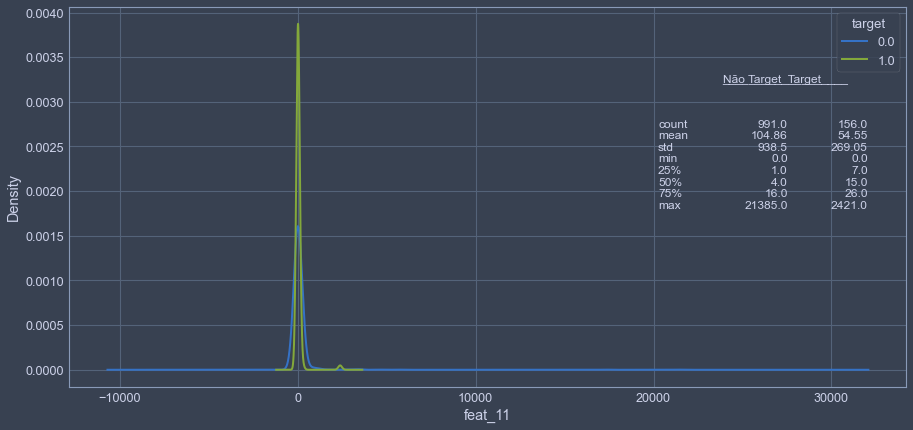

None

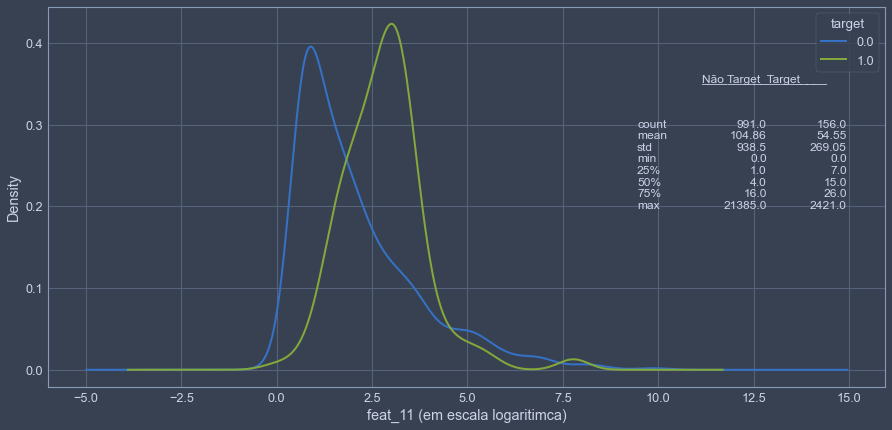

None

In [35]:
display(distribuicao_2(df1, 'feat_11', 1))
display(distribuicao_2(df1, 'feat_11', 0))

#### feat_12 x target

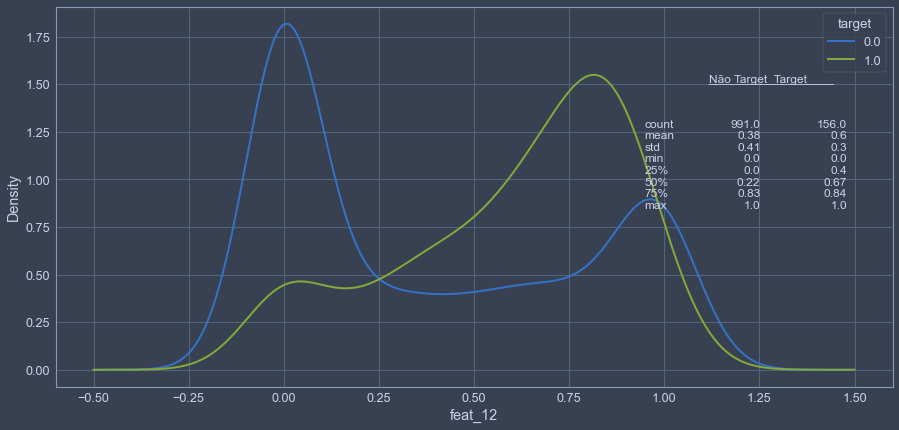

None

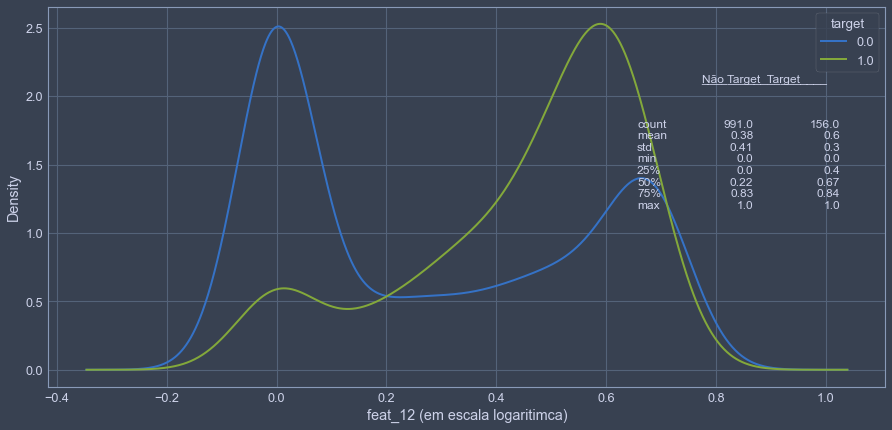

None

In [36]:
display(distribuicao_2(df1, 'feat_12', 1))
display(distribuicao_2(df1, 'feat_12', 0))

#### feat_13 x target

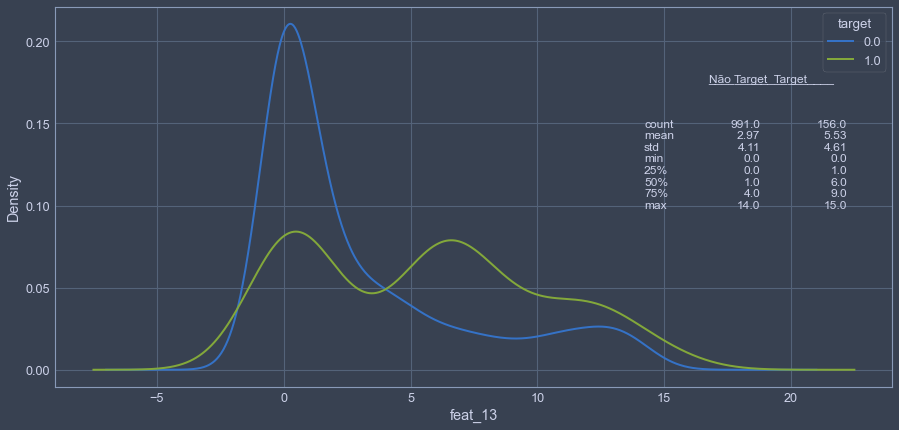

None

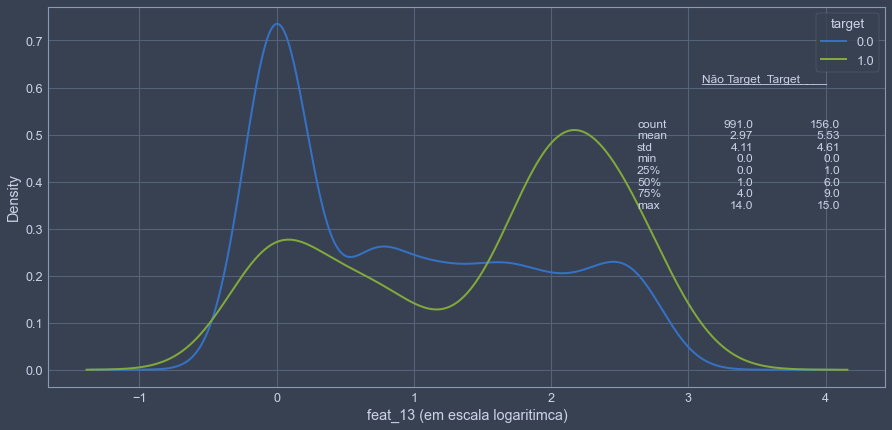

None

In [37]:
display(distribuicao_2(df1, 'feat_13', 1))
display(distribuicao_2(df1, 'feat_13', 0))

#### feat_14 x target

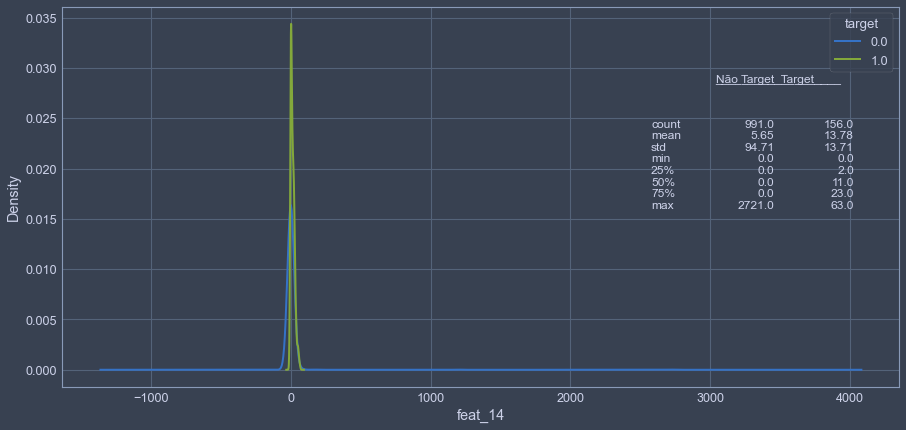

None

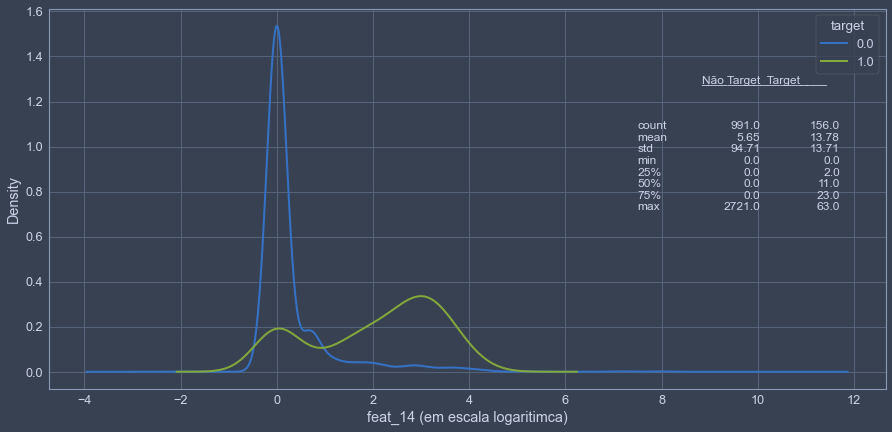

None

In [38]:
display(distribuicao_2(df1, 'feat_14', 1))
display(distribuicao_2(df1, 'feat_14', 0))

#### feat_15 x target

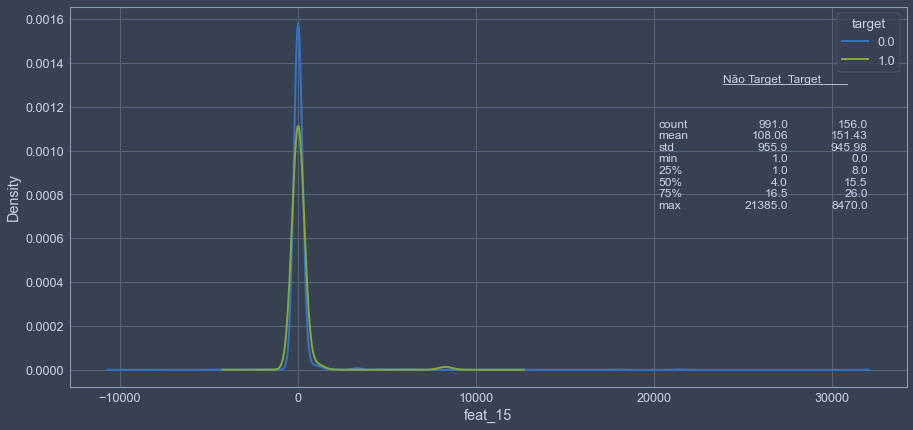

None

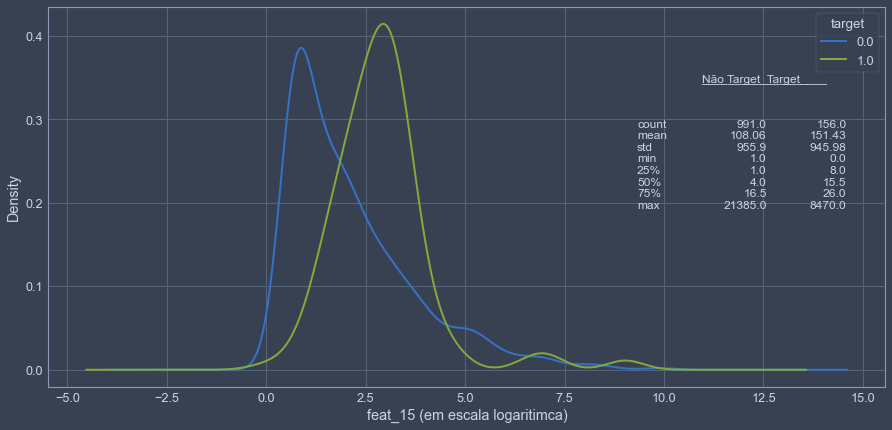

None

In [39]:
display(distribuicao_2(df1, 'feat_15', 1))
display(distribuicao_2(df1, 'feat_15', 0))

#### feat_16 x target

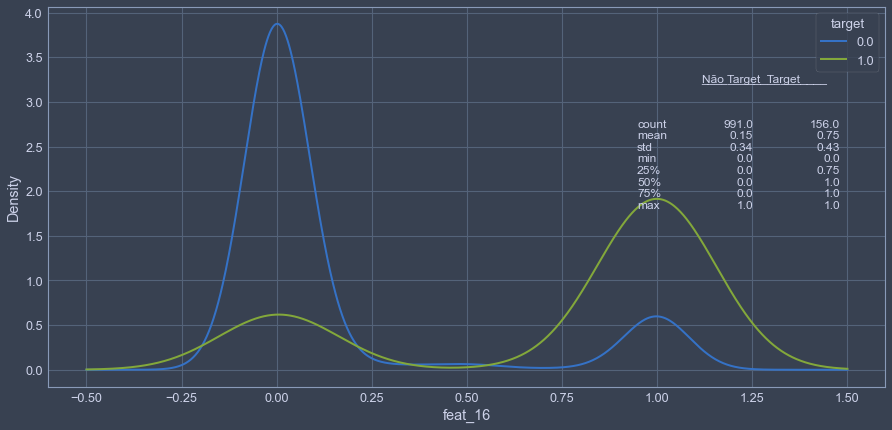

None

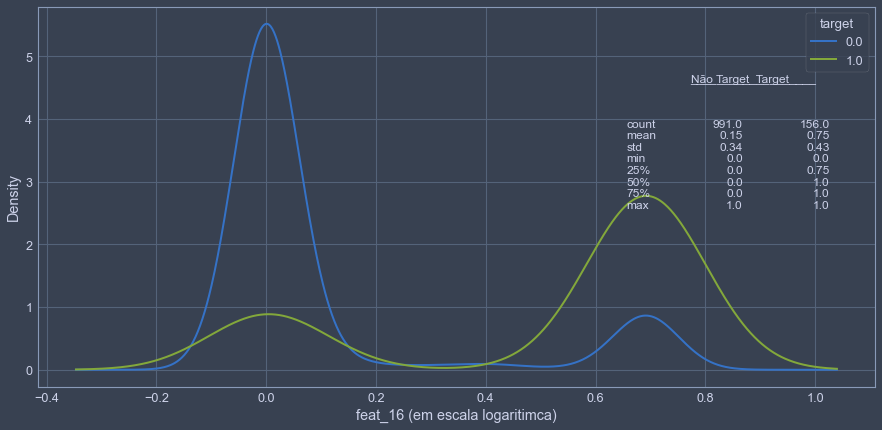

None

In [40]:
display(distribuicao_2(df1, 'feat_16', 1))
display(distribuicao_2(df1, 'feat_16', 0))

#### feat_17 x target

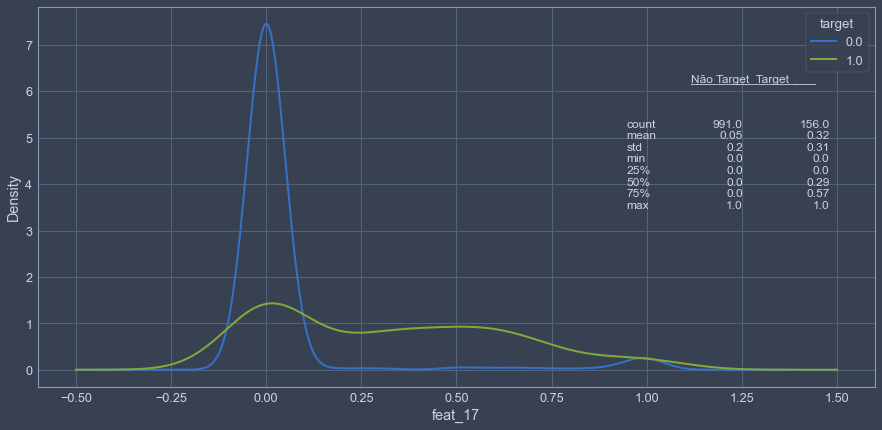

None

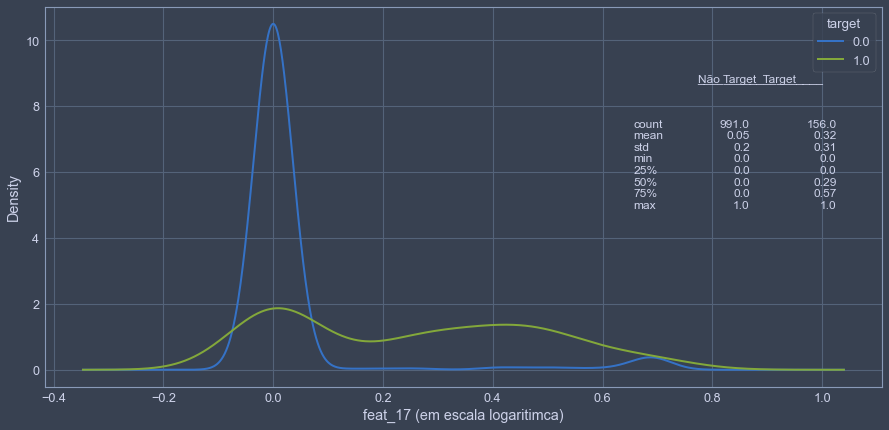

None

In [41]:
display(distribuicao_2(df1, 'feat_17', 1))
display(distribuicao_2(df1, 'feat_17', 0))

#### feat_18 x target

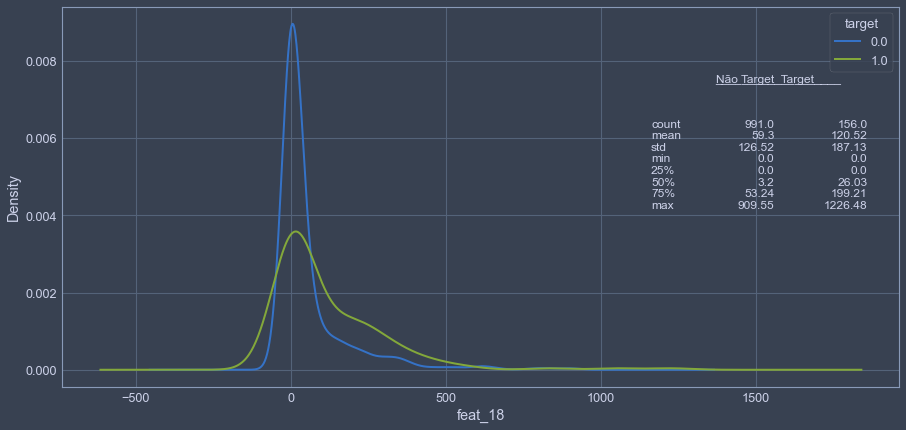

None

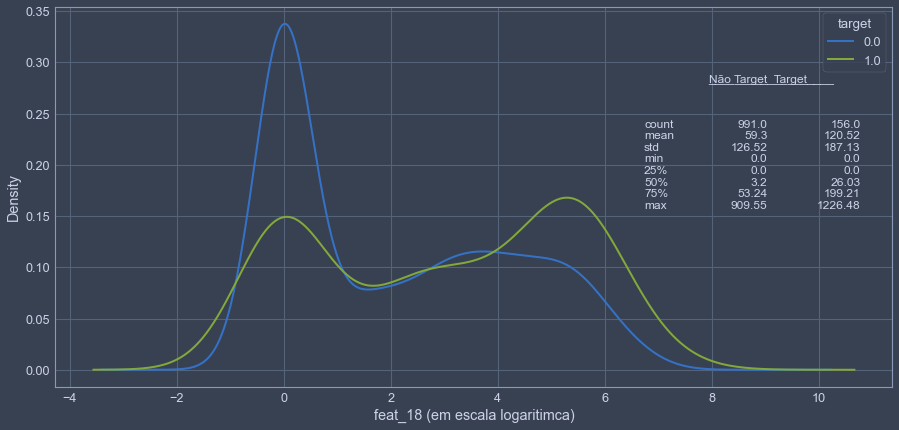

None

In [42]:
display(distribuicao_2(df1, 'feat_18', 1))
display(distribuicao_2(df1, 'feat_18', 0))

### Análise Multi-Variada

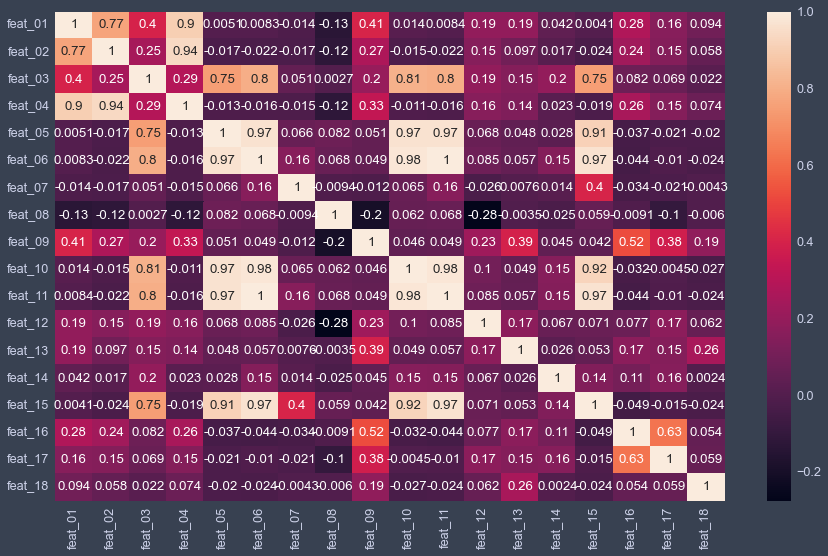

In [43]:
columns_corr= ['feat_01', 'feat_02', 'feat_03', 'feat_04', 'feat_05','feat_06', 'feat_07', 'feat_08', 'feat_09', 'feat_10', 'feat_11',
       'feat_12', 'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17','feat_18']
df_corr = df1[columns_corr].copy() ### Guardando valor de D2 para provas SEM WOE
#df_corr = df1.select_dtypes(include=['int64','float64','int32'])

fig = plt.figure(figsize =(15, 9))
correlation = df_corr.corr(method='pearson')
sns.heatmap(correlation,annot=True);

In [44]:
df1.columns

Index(['target', 'feat_01', 'feat_02', 'feat_03', 'feat_04', 'feat_05',
       'feat_06', 'feat_07', 'feat_08', 'feat_09', 'feat_10', 'feat_11',
       'feat_12', 'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17',
       'feat_18'],
      dtype='object')

## Engenharia de Recursos

### W.O.E.

#### Função BIN

In [90]:
def char_bin(Y, X):

    df3 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df3[['X', 'Y']][df3.X.isnull()]
    notmiss = df3[['X', 'Y']][df3.X.notnull()]
    df2 = notmiss.groupby('X', as_index=True)

    d3 = pd.DataFrame({}, index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y

    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE': np.nan}, index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4, ignore_index=True)

    d3["EVENT_RATE"] = d3.EVENT / d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT / d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT / d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT / d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT / d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT - d3.DIST_NON_EVENT) * np.log(
        d3.DIST_EVENT / d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[[
        'VAR_NAME', 'MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE',
        'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT', 'DIST_NON_EVENT', 'WOE',
        'IV'
    ]]
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)

    return (d3)

In [91]:
def data_vars(df, target):

    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]

    x = df.dtypes.index
    count = -1
    iv_df=[]
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df[i],
                             np.number) and len(Series.unique(df[i])) > 2:
                conv = mono_bin(target, df[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df[i])
                conv["VAR_NAME"] = i
                count = count + 1

            #if count == 0:
             #   iv_df = conv
            #else:
                #iv_df = iv_df.append(conv, ignore_index=True)
            if count == 0:
                iv_df = conv.copy()  # Crie uma cópia para a primeira iteração
            else:
                iv_df = pd.concat([iv_df, conv], ignore_index=True)

    iv = pd.DataFrame({'IV': iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return (iv_df, iv)

In [101]:
# Código que funciona com python 3.6

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n=max_bin):

    df3 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df3[['X', 'Y']][df3.X.isnull()]
    notmiss = df3[['X', 'Y']][df3.X.notnull()]
    r = 0

    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({
                "X": notmiss.X,
                "Y": notmiss.Y,
                "Bucket": pd.qcut(notmiss.X, n)
            })
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1] - (bins[1] / 2)
        d1 = pd.DataFrame({
            "X":
            notmiss.X,
            "Y":
            notmiss.Y,
            "Bucket":
            pd.cut(notmiss.X, np.unique(bins), include_lowest=True)
        })
        d2 = d1.groupby('Bucket', as_index=True)

    d3 = pd.DataFrame({}, index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3 = d3.reset_index(drop=True)

    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE': np.nan}, index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4, ignore_index=True)

    d3["EVENT_RATE"] = d3.EVENT / d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT / d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT / d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT / d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT / d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT - d3.DIST_NON_EVENT) * np.log(
        d3.DIST_EVENT / d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[[
        'VAR_NAME', 'MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE',
        'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT', 'DIST_NON_EVENT', 'WOE',
        'IV'
    ]]
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()

    return (d3)


def char_bin(Y, X):

    df3 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df3[['X', 'Y']][df3.X.isnull()]
    notmiss = df3[['X', 'Y']][df3.X.notnull()]
    df2 = notmiss.groupby('X', as_index=True)

    d3 = pd.DataFrame({}, index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y

    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE': np.nan}, index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4, ignore_index=True)

    d3["EVENT_RATE"] = d3.EVENT / d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT / d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT / d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT / d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT / d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT - d3.DIST_NON_EVENT) * np.log(
        d3.DIST_EVENT / d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[[
        'VAR_NAME', 'MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE',
        'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT', 'DIST_NON_EVENT', 'WOE',
        'IV'
    ]]
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)

    return (d3)


def data_vars(df1, target):

    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]

    x = df1.dtypes.index
    count = -1

    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i],
                             np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1

            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv, ignore_index=True)

    iv = pd.DataFrame({'IV': iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return (iv_df, iv)

#### Função WOE

In [102]:
# WOE

def show_woe(df, columns):
    final_iv, IV = data_vars(df[columns], df[columns].target)

    transform_vars_list = df[columns].columns.difference(['target'])
    transform_prefix = 'new_'
    df_ = df[select_columns].copy()

    for var in transform_vars_list:
        small_df = final_iv[final_iv['VAR_NAME'] == str(var)]
        transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
        replace_cmd = ''
        replace_cmd1 = ''
        for i in sorted(transform_dict.items()):
            replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
            replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
        replace_cmd = replace_cmd + '0'
        replace_cmd1 = replace_cmd1 + '0'
       # if replace_cmd != '0':
        #    try:
         #       df_[transform_prefix + var] = df_[var].apply(lambda x: eval(replace_cmd))
          #  except:
           #     df_[transform_prefix + var] = df_[var].apply(lambda x: eval(replace_cmd1))
        if replace_cmd != '0':
            try:
                df_[transform_prefix + var] = df_[var].apply(lambda x: eval(replace_cmd))
            except Exception as e:
                print(f"Erro ao aplicar a transformação em {var}: {str(e)}")
                df_[transform_prefix + var] = df_[var].apply(lambda x: eval(replace_cmd1))


    for c in select_columns:
        if c != 'target':
            small_df = final_iv[final_iv['VAR_NAME'] == c]
            print("COLUMNA: " + c)
            display(small_df)

In [103]:
select_columns = ['target', 
                  'feat_01',
                  'feat_02',
                  'feat_03',
                  'feat_04',
                  'feat_05',
                  'feat_06', 
                  'feat_07', 
                  'feat_08',
                  'feat_09',
                  'feat_10',
                  'feat_11',
                  'feat_12', 
                  'feat_13',
                  'feat_14',
                  'feat_15',
                  'feat_16',
                  'feat_17',
                  'feat_18'
                 ]

In [104]:
df1.head()

target    feat_01   feat_02    feat_03   feat_04  feat_05  feat_06  \
0     1.0     208.22    113.98    1595.71     48.51      8.0     14.0   
1     1.0   34466.92  12055.28  554542.89  10817.01      5.0     46.0   
2     1.0     719.60    181.62  439700.60     21.49    357.0   2421.0   
3     1.0  149861.15  13274.80  384969.15  29656.99      2.0     29.0   
4     1.0  124175.13  17472.00  384384.06  32525.45      1.0     22.0   

   feat_07  feat_08  feat_09  feat_10  feat_11  feat_12  feat_13  feat_14  \
0      5.0     0.57      1.0      8.0     14.0     0.57      0.0      0.0   
1      1.0     0.11      0.0     12.0     46.0     0.26      0.0     47.0   
2   3566.0     0.15      0.0    387.0   2421.0     0.16      6.0     11.0   
3      0.0     0.07      1.0     24.0     29.0     0.83     11.0     29.0   
4      0.0     0.05      1.0     16.0     22.0     0.73     10.0     22.0   

   feat_15  feat_16  feat_17  feat_18  
0     19.0      0.0     0.00   140.71  
1     47.0      1.0     0.96   128.83  
2   8128.0      0.0     0.00    28.98  
3     29.0      1.0     0.54    35.51  
4     22.0      1.0     0.29   567.32

#### Aplicando WOE

In [105]:
show_woe(df1, select_columns) 

Erro ao aplicar a transformação em feat_15: name 'nan' is not defined
COLUMNA: feat_01


VAR_NAME  MIN_VALUE   MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
0  feat_01       0.00      180.32    383    4.0    0.010444     379.0   
1  feat_01     180.71     1790.00    382    9.0    0.023560     373.0   
2  feat_01    1800.00  1500000.00    382  143.0    0.374346     239.0   

   NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT       WOE        IV  
0        0.989556    0.025641        0.382442 -2.702383  2.463873  
1        0.976440    0.057692        0.376387 -1.875495  2.463873  
2        0.625654    0.916667        0.241171  1.335240  2.463873

COLUMNA: feat_02


VAR_NAME  MIN_VALUE  MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
3  feat_02       0.00      83.26    287    4.0    0.013937     283.0   
4  feat_02      83.77     219.22    287    5.0    0.017422     282.0   
5  feat_02     219.48    1421.56    286   10.0    0.034965     276.0   
6  feat_02    1439.70  345123.17    287  137.0    0.477352     150.0   

   NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT       WOE        IV  
3        0.986063    0.025641        0.285570 -2.410294  2.770777  
4        0.982578    0.032051        0.284561 -2.183611  2.770777  
5        0.965035    0.064103        0.278507 -1.468957  2.770777  
6        0.522648    0.878205        0.151362  1.758204  2.770777

COLUMNA: feat_03


VAR_NAME  MIN_VALUE    MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
7  feat_03       0.00       424.67    383    4.0    0.010444     379.0   
8  feat_03     425.81      9301.48    382    9.0    0.023560     373.0   
9  feat_03    9690.07  12187323.86    382  143.0    0.374346     239.0   

   NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT       WOE        IV  
7        0.989556    0.025641        0.382442 -2.702383  2.463873  
8        0.976440    0.057692        0.376387 -1.875495  2.463873  
9        0.625654    0.916667        0.241171  1.335240  2.463873

COLUMNA: feat_04


VAR_NAME  MIN_VALUE  MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
10  feat_04       0.00       8.83    383    4.0    0.010444     379.0   
11  feat_04       9.00     315.41    382    7.0    0.018325     375.0   
12  feat_04     317.85  543212.65    382  145.0    0.379581     237.0   

    NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT       WOE        IV  
10        0.989556    0.025641        0.382442 -2.702383  2.612511  
11        0.981675    0.044872        0.378406 -2.132157  2.612511  
12        0.620419    0.929487        0.239152  1.357532  2.612511

COLUMNA: feat_05


VAR_NAME  MIN_VALUE  MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
13  feat_05        0.0        1.0    753  127.0    0.168659     626.0   
14  feat_05        2.0    18446.0    394   29.0    0.073604     365.0   

    NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT       WOE        IV  
13        0.831341    0.814103        0.631685  0.253695  0.171005  
14        0.926396    0.185897        0.368315 -0.683743  0.171005

COLUMNA: feat_06


VAR_NAME  MIN_VALUE  MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
15  feat_06        0.0        1.0    289    3.0    0.010381     286.0   
16  feat_06        2.0        5.0    305   27.0    0.088525     278.0   
17  feat_06        6.0       20.0    270   61.0    0.225926     209.0   
18  feat_06       21.0    21385.0    283   65.0    0.229682     218.0   

    NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT       WOE        IV  
15        0.989619    0.019231        0.288597 -2.708521  1.018319  
16        0.911475    0.173077        0.280525 -0.482926  1.018319  
17        0.774074    0.391026        0.210898  0.617398  1.018319  
18        0.770318    0.416667        0.219980  0.638751  1.018319

COLUMNA: feat_07


VAR_NAME  MIN_VALUE  MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
19  feat_07        0.0        1.0   1037  148.0    0.142719     889.0   
20  feat_07        2.0     3566.0    110    8.0    0.072727     102.0   

    NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT       WOE       IV  
19        0.857281    0.948718        0.897074  0.055974  0.03887  
20        0.927273    0.051282        0.102926 -0.696673  0.03887

COLUMNA: feat_08


VAR_NAME  MIN_VALUE  MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
21  feat_08       0.00       0.15    578  131.0    0.226644     447.0   
22  feat_08       0.16       1.00    569   25.0    0.043937     544.0   

    NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT       WOE       IV  
21        0.773356    0.839744         0.45106  0.621497  0.72012  
22        0.956063    0.160256         0.54894 -1.231215  0.72012

COLUMNA: feat_09


VAR_NAME  MIN_VALUE  MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
23  feat_09        0.0        0.0   1028   61.0    0.059339     967.0   
24  feat_09        1.0        1.0    119   95.0    0.798319      24.0   

    NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT       WOE        IV  
23        0.940661    0.391026        0.975782 -0.914466  2.420393  
24        0.201681    0.608974        0.024218  3.224682  2.420393

COLUMNA: feat_10


VAR_NAME  MIN_VALUE  MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
25  feat_10        0.0        2.0    605   32.0    0.052893     573.0   
26  feat_10        3.0    20214.0    542  124.0    0.228782     418.0   

    NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT       WOE        IV  
25        0.947107    0.205128        0.578204 -1.036291  0.623018  
26        0.771218    0.794872        0.421796  0.633659  0.623018

COLUMNA: feat_11


VAR_NAME  MIN_VALUE  MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
27  feat_11        0.0        1.0    289    3.0    0.010381     286.0   
28  feat_11        2.0        5.0    308   27.0    0.087662     281.0   
29  feat_11        6.0       20.0    267   61.0    0.228464     206.0   
30  feat_11       21.0    21385.0    283   65.0    0.229682     218.0   

    NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT       WOE        IV  
27        0.989619    0.019231        0.288597 -2.708521  1.025484  
28        0.912338    0.173077        0.283552 -0.493659  1.025484  
29        0.771536    0.391026        0.207871  0.631856  1.025484  
30        0.770318    0.416667        0.219980  0.638751  1.025484

COLUMNA: feat_12


VAR_NAME  MIN_VALUE  MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
31  feat_12       0.00       0.33    578   30.0    0.051903     548.0   
32  feat_12       0.34       1.00    569  126.0    0.221441     443.0   

    NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT       WOE        IV  
31        0.948097    0.192308        0.552977 -1.056219  0.594307  
32        0.778559    0.807692        0.447023  0.591571  0.594307

COLUMNA: feat_13


VAR_NAME  MIN_VALUE  MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
33  feat_13        0.0        1.0    617   55.0    0.089141     562.0   
34  feat_13        2.0       15.0    530  101.0    0.190566     429.0   

    NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT       WOE       IV  
33        0.910859    0.352564        0.567104 -0.475310  0.18833  
34        0.809434    0.647436        0.432896  0.402522  0.18833

COLUMNA: feat_14


VAR_NAME  MIN_VALUE  MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
35  feat_14        0.0        1.0    923   38.0    0.041170     885.0   
36  feat_14        2.0     2721.0    224  118.0    0.526786     106.0   

    NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT       WOE        IV  
35        0.958830     0.24359        0.893037 -1.299143  2.114112  
36        0.473214     0.75641        0.106963  1.956104  2.114112

COLUMNA: feat_15


VAR_NAME  MIN_VALUE  MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
37  feat_15        0.0        1.0    287    3.0    0.010453     284.0   
38  feat_15        NaN        NaN      0    0.0         NaN       0.0   
39  feat_15        2.0        3.0    182   11.0    0.060440     171.0   
40  feat_15        4.0        6.0    145   18.0    0.124138     127.0   
41  feat_15        7.0       10.0    115   21.0    0.182609      94.0   
42  feat_15       11.0       20.0    131   38.0    0.290076      93.0   
43  feat_15       21.0       48.0    146   50.0    0.342466      96.0   
44  feat_15       49.0    21385.0    141   15.0    0.106383     126.0   

    NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT       WOE        IV  
37        0.989547    0.019231        0.286579 -2.701503  1.247905  
38             NaN    0.000000        0.000000       NaN  1.247905  
39        0.939560    0.070513        0.172553 -0.894910  1.247905  
40        0.875862    0.115385        0.128153 -0.104957  1.247905  
41        0.817391    0.134615        0.094854  0.350086  1.247905  
42        0.709924    0.243590        0.093845  0.953845  1.247905  
43        0.657534    0.320513        0.096872  1.196533  1.247905  
44        0.893617    0.096154        0.127144 -0.279373  1.247905

COLUMNA: feat_16


VAR_NAME  MIN_VALUE  MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
45  feat_16        0.0        1.0   1147  156.0    0.136007     991.0   

    NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT  WOE   IV  
45        0.863993         1.0             1.0  0.0  0.0

COLUMNA: feat_17


VAR_NAME  MIN_VALUE  MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
46  feat_17        0.0        1.0   1147  156.0    0.136007     991.0   

    NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT  WOE   IV  
46        0.863993         1.0             1.0  0.0  0.0

COLUMNA: feat_18


VAR_NAME  MIN_VALUE  MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
47  feat_18       0.00       4.62    574   51.0    0.088850     523.0   
48  feat_18       4.64    1226.48    573  105.0    0.183246     468.0   

    NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT       WOE        IV  
47        0.911150    0.326923         0.52775 -0.478897  0.167338  
48        0.816754    0.673077         0.47225  0.354351  0.167338

#### Aplicando Cortes WOE

In [18]:
df2 = df1.copy()

In [64]:
df2['high_value_feat_01'] = df2['feat_01'] >= 1800
df2['high_value_feat_02'] = df2['feat_02'] >= 1439
df2['high_value_feat_03'] = df2['feat_03'] >= 9301
df2['high_value_feat_04'] = df2['feat_04'] >= 317
df2['high_value_feat_05'] = df2['feat_05'] >= 2 
df2['high_value_feat_06'] = df2['feat_06'] >= 21
df2['high_value_feat_07'] = df2['feat_07'] >= 2
df2['high_value_feat_08'] = df2['feat_08'] <= 0.15
df2['high_value_feat_09'] = df2['feat_09'] >= 1
df2['high_value_feat_10'] = df2['feat_10'] >= 3
df2['high_value_feat_11'] = df2['feat_11'] >= 21
df2['high_value_feat_12'] = df2['feat_12'] >= 0.34
df2['high_value_feat_13'] = df2['feat_13'] >= 2
df2['high_value_feat_14'] = df2['feat_14'] >= 2
df2['high_value_feat_15'] = df2['feat_15'] >= 21
df2['high_value_feat_18'] = df2['feat_18'] >= 4.64

In [65]:
columns_cross_t = [
    'high_value_feat_01',
    'high_value_feat_02',
    'high_value_feat_03',
    'high_value_feat_04',
    'high_value_feat_05',
    'high_value_feat_06',
    'high_value_feat_07',
    'high_value_feat_08',
    'high_value_feat_09',
    'high_value_feat_10',
    'high_value_feat_11',
    'high_value_feat_12',
    'high_value_feat_13',
    'high_value_feat_14',
    'high_value_feat_15',
    'high_value_feat_18'
]

In [66]:
X = df2[columns_cross_t]
y = df2['target']

In [67]:
df_gp = df2[columns_cross_t]
df_gp['target'] = df2['target']

In [68]:
df_extra= df_gp.copy()

Text(0.5, 1.0, 'Triangle Correlation Heatmap')

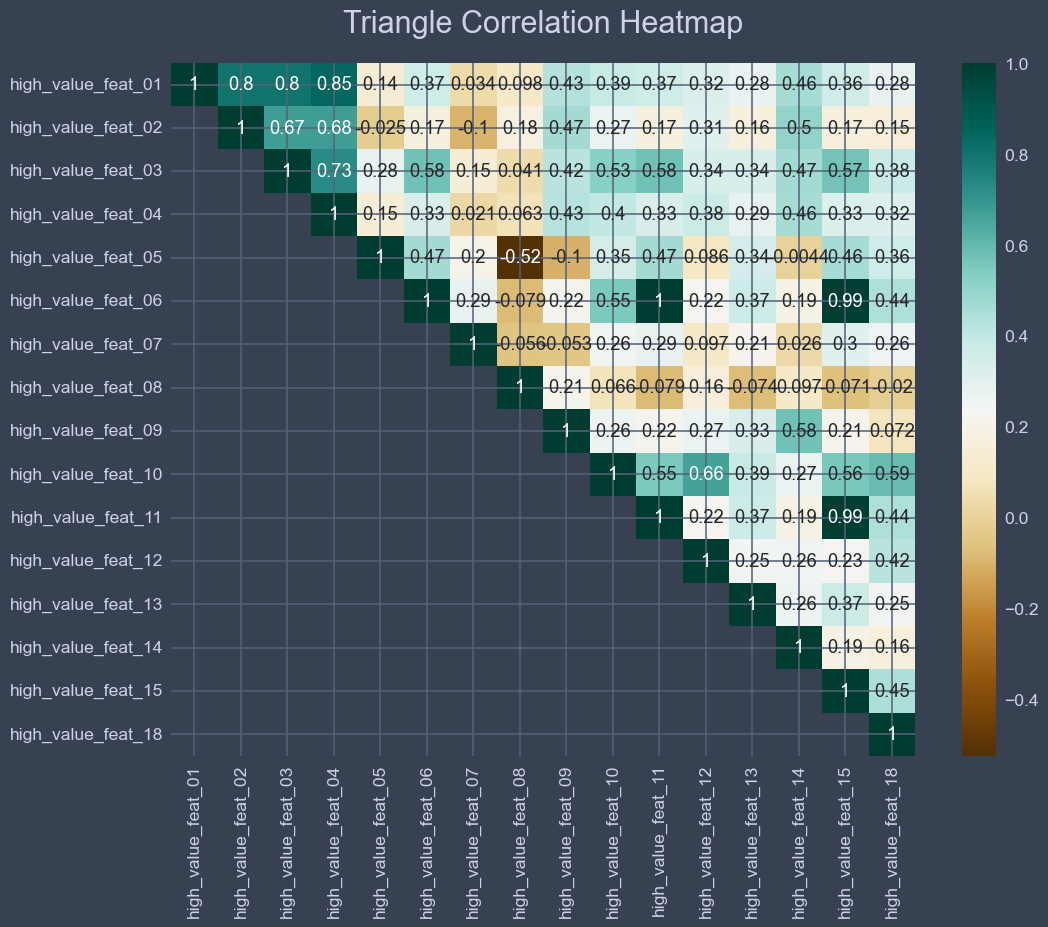

In [58]:
# Define o tamanho da figura do mapa de calor
plt.figure(figsize=(12, 9))

# Cria a matriz de correlação
corr_matrix = df_gp.drop(columns=['target'], axis=1).corr()

# Define uma máscara para a metade inferior da matriz de correlação
mask = np.tri(corr_matrix.shape[0], k=-1, dtype=bool)

# Cria o mapa de calor da matriz de correlação com a máscara
heatmap = sns.heatmap(corr_matrix,
                      mask=mask,
                      annot=True,
                      cmap='BrBG')

# Define o título do mapa de calor
heatmap.set_title('Triangle Correlation Heatmap',
                  fontdict={'fontsize': 22},
                  pad=22)

<Axes: >

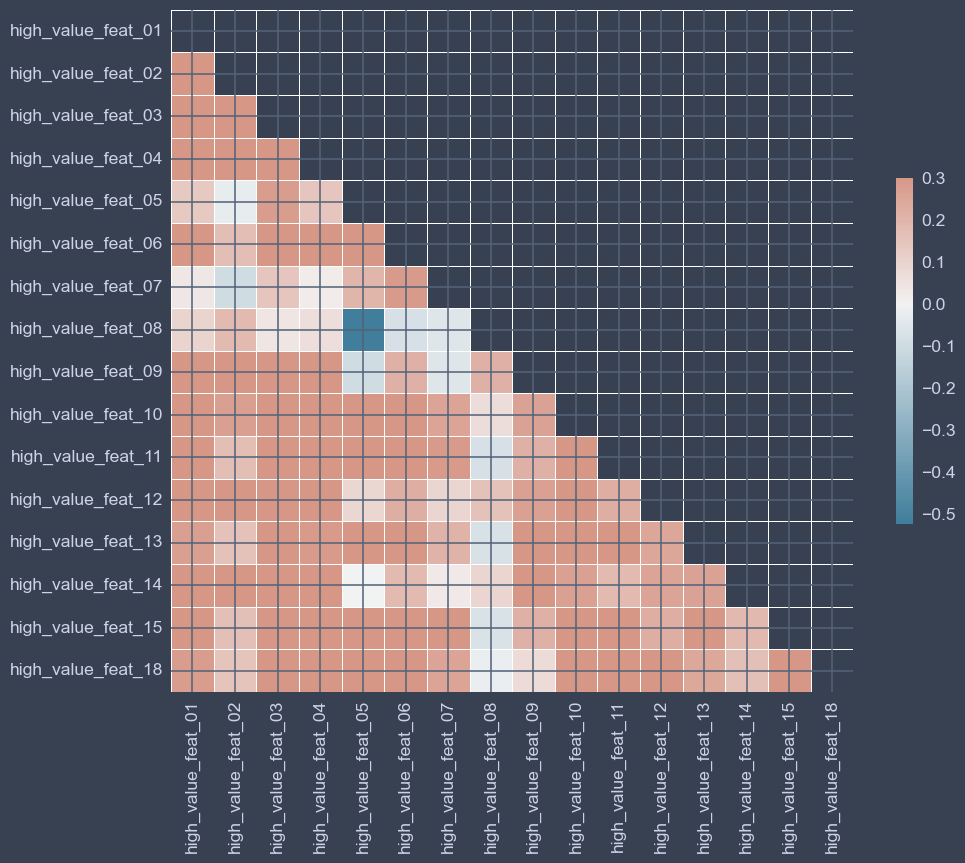

In [59]:
corr = df_gp.drop(columns=['target'], axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=.3,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})

### Random Forest Best Selection

In [19]:
dfx = df.copy()

Random forest features importance:


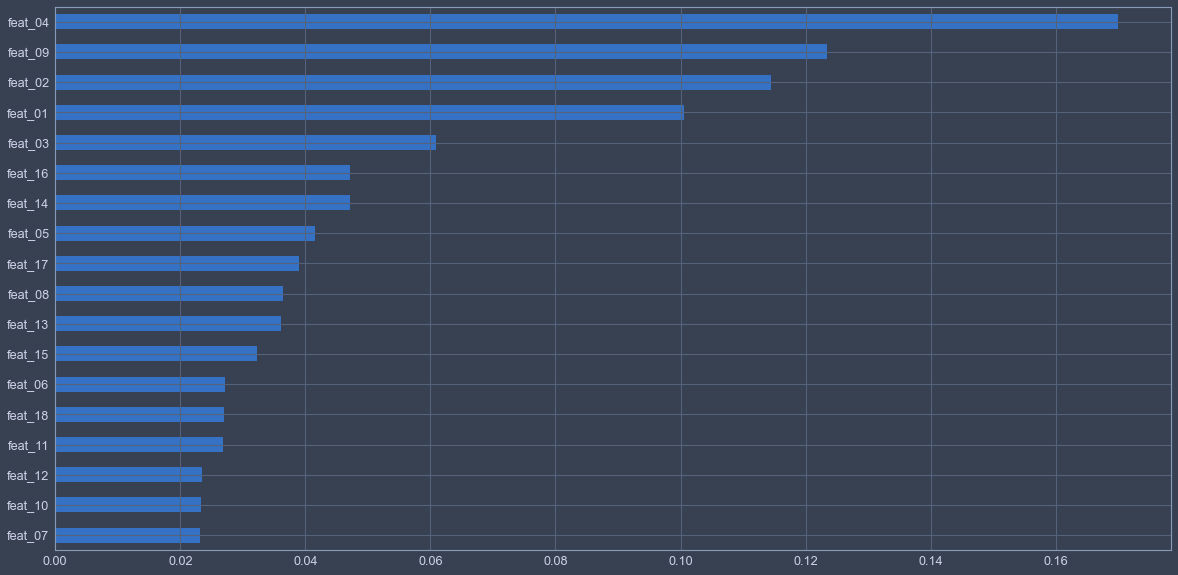

In [76]:
# define random forest model
rf_model = RandomForestClassifier(n_jobs= -1)
# define the train arrays
x_train_rfc = dfx.drop(columns= ['target'])
y_train_rfc = dfx['target']
# train the random forest model
rf_model.fit(x_train_rfc, y_train_rfc)
# create a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (20, 10))
# create a series and plot the model's features importance
feat_importances = pd.Series(rf_model.feature_importances_, index= x_train_rfc.columns)
print('Random forest features importance:')
feat_importances.sort_values().plot(kind= 'barh');

### Recursive Feature Elimination (RFE)

In [77]:
# defining random forest model
rf = RandomForestClassifier(n_jobs= -1)

# defining the train arrays
x_train_rfe = dfx.drop(columns= ['target'])
y_train_rfe = dfx['target']

# defining the amount of features to select
rfe_selector = RFE(rf, n_features_to_select= 10, step= 1)
# training the model
rfe_selector = rfe_selector.fit(x_train_rfe, y_train_rfe)
# ranking the beast features
selected_features_T_F = rfe_selector.support_.tolist()

# getting the selected features columns names
features_columns = x_train_rfe.columns

# instantiating an empty list
rfe_selected_features = []

# inserting the selected columns into the empty list
for binary, feature in zip(selected_features_T_F, features_columns):
    if binary == True:
        rfe_selected_features.append(feature)

# displaying the selected features by RFE
print('RFE selected features:')
rfe_selected_features

RFE selected features:


['feat_01',
 'feat_02',
 'feat_03',
 'feat_04',
 'feat_05',
 'feat_08',
 'feat_09',
 'feat_14',
 'feat_15',
 'feat_17']

### Método Boruta Selection

In [71]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   target   1148 non-null   float64
 1   feat_01  1148 non-null   float64
 2   feat_02  1148 non-null   float64
 3   feat_03  1148 non-null   float64
 4   feat_04  1148 non-null   float64
 5   feat_05  1148 non-null   float64
 6   feat_06  1148 non-null   float64
 7   feat_07  1148 non-null   float64
 8   feat_08  1148 non-null   float64
 9   feat_09  1148 non-null   float64
 10  feat_10  1148 non-null   float64
 11  feat_11  1148 non-null   float64
 12  feat_12  1148 non-null   float64
 13  feat_13  1148 non-null   float64
 14  feat_14  1148 non-null   float64
 15  feat_15  1148 non-null   float64
 16  feat_16  1148 non-null   float64
 17  feat_17  1148 non-null   float64
 18  feat_18  1148 non-null   float64
dtypes: float64(19)
memory usage: 170.5 KB


In [79]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# defining model that will be checked by the boruta method
rf_model = RandomForestClassifier(n_jobs = -1)
# defining the train arrays
x_train_boruta = dfx.drop(columns= ['target']).values
y_train_boruta = dfx['target'].values.ravel()

# instantiating the boruta method
boruta = BorutaPy(rf_model, n_estimators='auto', verbose= 2)
# training the boruta method
boruta.fit(x_train_boruta, y_train_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	12
Tentative: 	6
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	12
Tentative: 	6
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	12
Tentative: 	6
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	12
Tentative: 	6
Rejected: 	0
Iteration: 	16 / 100
Confirmed: 	12
Tentative: 	5
Rejected: 	1
I

BorutaPy(estimator=RandomForestClassifier(n_estimators=58, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x148C9653150),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x148C9653150, verbose=2)

In [80]:
# instantiating the dataset selected columns by the boruta method
cols = boruta.support_.tolist()
boruta_selected_features = dfx.drop(columns= ['target']).iloc[:, cols].columns.to_list()

# displaying the selected features by boruta
print('Boruta selected features:')
boruta_selected_features

Boruta selected features:


['feat_01',
 'feat_02',
 'feat_03',
 'feat_04',
 'feat_05',
 'feat_06',
 'feat_08',
 'feat_09',
 'feat_11',
 'feat_13',
 'feat_14',
 'feat_15',
 'feat_16',
 'feat_17']

## Modelos

### Preparação 

In [20]:
seed = 6
np.random.seed(seed)
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

In [85]:
# Feature Boruta

columns = ['feat_01',
           'feat_02',
           'feat_03',
           'feat_04',
           'feat_05',
           'feat_06',
           'feat_08',
           'feat_09',
           'feat_13',
           'feat_14',
           'feat_15',
           'feat_16',
           'feat_17'
          ]

#### Rescaling Data

In [86]:
df20 = df.copy()

In [87]:
rs = RobustScaler()

df20['feat_01'] = rs.fit_transform(df20[['feat_01']].values)
df20['feat_02'] = rs.fit_transform(df20[['feat_02']].values)
df20['feat_03'] = rs.fit_transform(df20[['feat_03']].values)
df20['feat_04'] = rs.fit_transform(df20[['feat_04']].values)
df20['feat_05'] = rs.fit_transform(df20[['feat_05']].values)
df20['feat_06'] = rs.fit_transform(df20[['feat_06']].values)
df20['feat_08'] = rs.fit_transform(df20[['feat_08']].values)
df20['feat_09'] = rs.fit_transform(df20[['feat_09']].values)
df20['feat_14'] = rs.fit_transform(df20[['feat_14']].values)
df20['feat_15'] = rs.fit_transform(df20[['feat_15']].values)
df20['feat_16'] = rs.fit_transform(df20[['feat_16']].values)
df20['feat_17'] = rs.fit_transform(df20[['feat_17']].values)

#### Train/Test Data

In [88]:
X = df20[columns]
y = df['target']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=seed,
                                                    shuffle=True,
                                                    stratify=y)

#### Balanceamento dos Dados

In [90]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 125
Before OverSampling, counts of label '0': 793 



In [91]:
cv = KFold(n_splits=10, shuffle=True, random_state=seed)

Best parameters : {'smote__sampling_strategy': 0.654795918367347}


<AxesSubplot:xlabel='weight'>

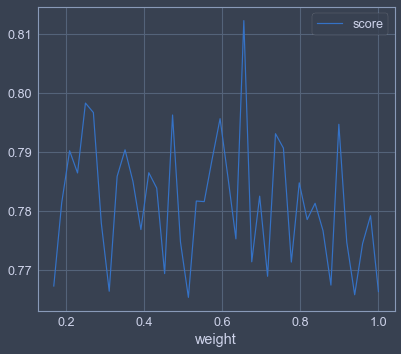

In [92]:
pipe = make_pipeline(
    SMOTE(),
    GradientBoostingClassifier()
)
weights = np.linspace(0.005, 1, 50)
gsc = GridSearchCV(
    estimator=pipe,
    param_grid={
        'smote__sampling_strategy': weights
    },
    scoring='f1',
    cv=cv
)
grid_result = gsc.fit(X_train, y_train)
print("Best parameters : %s" % grid_result.best_params_)
weight_f1_score_df = pd.DataFrame(
    {
        'score': grid_result.cv_results_['mean_test_score'],
        'weight': weights
    }
)
weight_f1_score_df.plot(x='weight')

In [93]:
#ros = SMOTE(random_state=seed, sampling_strategy= 0.6954081632653062) melhor resultado
ros = SMOTE(random_state=seed, sampling_strategy= 0.654795918367347)
X_train_over, y_train_over = ros.fit_resample(X_train, y_train)

#### Validação Cruzada

In [94]:
cv = KFold(n_splits=10, shuffle=True, random_state=seed)

In [95]:
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train_over, y_train_over)

DecisionTreeClassifier(max_depth=5)

### Aplicação de Algoritmos

#### XGBoost

In [31]:
!pip install xgboost


In [32]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [96]:
# Crie um modelo XGBoost para classificação
XGBoost_model = xgb.XGBClassifier(
    max_depth=3,              # Profundidade máxima da árvore
    learning_rate=0.1,        # Taxa de aprendizado
    n_estimators=100,         # Número de árvores de decisão (iterações)
    objective='multi:softmax',  # Função de perda para classificação multiclasse
    num_class=len(y.unique())  # Número de classes no rótulo
)

# Treine o modelo XGBoost
XGBoost_model.fit(X_train_over, y_train_over)

[02:40:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_class=2, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [97]:
# Faça previsões no conjunto de teste
xg_predict = XGBoost_model.predict(X_test)

In [98]:
scorex = accuracy_score(y_test ,xg_predict)
precisionx = precision_score(y_test,xg_predict)
recallx = recall_score(y_test,xg_predict)

In [99]:
print('Accuracia: {0:0.2f} '.format(scorex))
print('Precision: {0:0.2f} '.format(precisionx))
print('Recall: {0:0.2f} '.format(recallx))

Accuracia: 0.96 
Precision: 0.84 
Recall: 0.84 


#### DT Model

In [100]:
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 40),
    'min_impurity_decrease': np.arange(0.0, 0.3, 0.05)
}

n_iter_search = 50

random_search = RandomizedSearchCV(estimator=tree,
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                   cv=cv,
                                   scoring='f1')

random_search.fit(X_train_over, y_train_over)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=6, shuffle=True),
                   estimator=DecisionTreeClassifier(max_depth=5), n_iter=50,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 40),
                                        'min_impurity_decrease': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25])},
                   scoring='f1')

In [101]:
random_search.best_params_

{'min_impurity_decrease': 0.0, 'max_depth': 7, 'criterion': 'gini'}

In [102]:
model_tree = DecisionTreeClassifier(max_depth=3, criterion='gini')
model_tree.fit(X_train_over, y_train_over)

DecisionTreeClassifier(max_depth=3)

In [103]:
tree_predic = model_tree.predict(X_test)

score = accuracy_score(y_test ,tree_predic)
precision = precision_score(y_test,tree_predic)
recall = recall_score(y_test,tree_predic)

In [104]:
print('Accuracia: {0:0.2f} '.format(score))
print('Precision: {0:0.2f} '.format(precision))
print('Recall: {0:0.2f} '.format(recall))

Accuracia: 0.94 
Precision: 0.74 
Recall: 0.84 


#### Logistic Regression 

In [105]:
model_rl = LogisticRegression()
model_rl.fit(X_train_over, y_train_over)

LogisticRegression()

In [106]:
pred = model_rl.predict(X_test)

score1 = accuracy_score(y_test ,pred)
precision1 = precision_score(y_test, pred)
recall1 = recall_score(y_test, pred)

In [107]:
print('Acuracia: {0:0.2f} '.format(score1))
print('Precision: {0:0.2f} '.format(precision1))
print('Recall: {0:0.2f} '.format(recall1))

Acuracia: 0.93 
Precision: 0.75 
Recall: 0.77 


#### Random Forest

In [108]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                              random_state=0)

In [109]:
clf.fit(X_train_over, y_train_over)
# performing predictions on the test dataset
y_pred_rf = clf.predict(X_test)

score_rf = accuracy_score(y_test ,y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

In [110]:
print('Acuracia RF: {0:0.2f} '.format(score_rf))
print('Precision RF: {0:0.2f} '.format(precision_rf))
print('Recall RF: {0:0.2f} '.format(recall_rf))

Acuracia RF: 0.92 
Precision RF: 0.66 
Recall RF: 0.81 


In [111]:

# load JS visualization code to notebook SHAP
shap.initjs()
explainer = shap.TreeExplainer(XGBoost_model)
shap_values = explainer.shap_values(X_train_over)

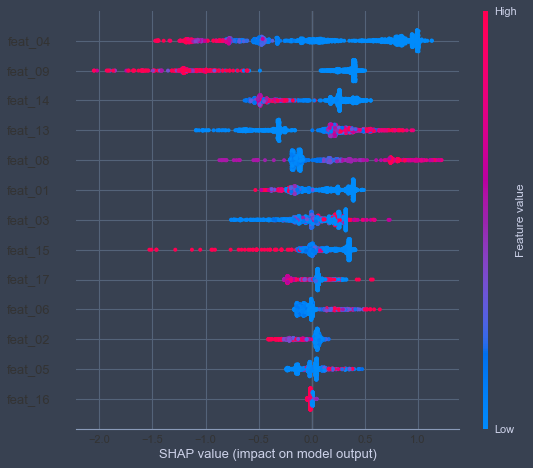

In [112]:
plt.figure(figsize=(15, 10))
shap.summary_plot(shap_values[0], X_train_over)

## Performance dos Modelos

<Figure size 1080x720 with 0 Axes>

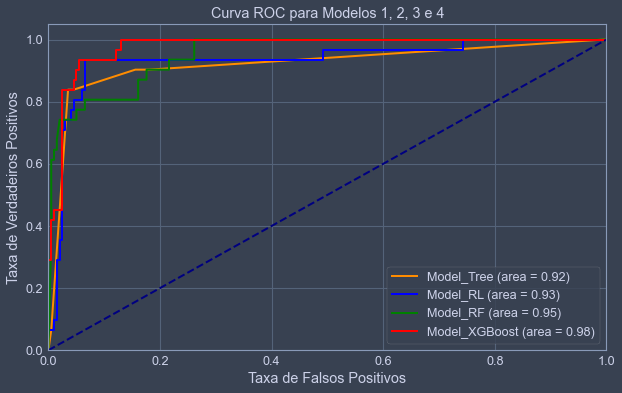

In [113]:
plt.figure(figsize=(15, 10))
# Calcule as probabilidades previstas para cada modelo
probas_1 = model_tree.predict_proba(X_test)[:, 1]
probas_2 = model_rl.predict_proba(X_test)[:, 1]
probas_3 = clf.predict_proba(X_test)[:, 1]
probas_4 = XGBoost_model.predict_proba(X_test)[:, 1]

# Calcule as curvas ROC para cada modelo
fpr_1, tpr_1, _ = roc_curve(y_test, probas_1)
roc_auc_1 = auc(fpr_1, tpr_1)

fpr_2, tpr_2, _ = roc_curve(y_test, probas_2)
roc_auc_2 = auc(fpr_2, tpr_2)

fpr_3, tpr_3, _ = roc_curve(y_test, probas_3)
roc_auc_3 = auc(fpr_3, tpr_3)

fpr_4, tpr_4, _ = roc_curve(y_test, probas_4)
roc_auc_4 = auc(fpr_4, tpr_4)

# Plote as curvas ROC para cada modelo no mesmo gráfico
plt.figure(figsize=(10, 6))
plt.plot(fpr_1, tpr_1, color='darkorange', lw=2, label='Model_Tree (area = %0.2f)' % roc_auc_1)
plt.plot(fpr_2, tpr_2, color='blue', lw=2, label='Model_RL (area = %0.2f)' % roc_auc_2)
plt.plot(fpr_3, tpr_3, color='green', lw=2, label='Model_RF (area = %0.2f)' % roc_auc_3)
plt.plot(fpr_4, tpr_4, color='red', lw=2, label='Model_XGBoost (area = %0.2f)' % roc_auc_4)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC para Modelos 1, 2, 3 e 4')
plt.legend(loc='lower right')
plt.show()

### Matriz de Confusão

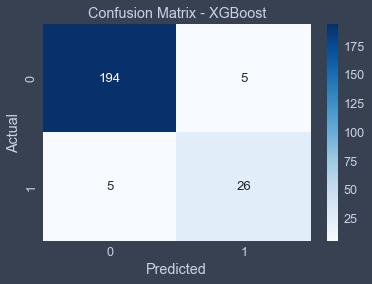

In [114]:
# Calcular a matriz de confusão para o modelo de XGBoost
cm_xgb = confusion_matrix(y_test, XGBoost_model.predict(X_test))

# Plotar a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()


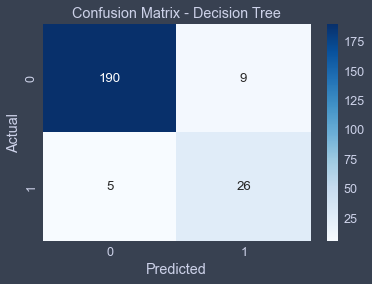

In [115]:
# Calcular a matriz de confusão para o modelo de Árvore de Decisão
cm_tree = confusion_matrix(y_test, model_tree.predict(X_test))

# Plotar a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.show()


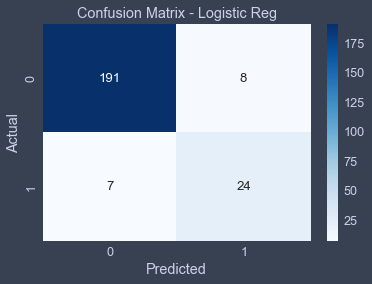

In [116]:
# Calcular a matriz de confusão para o modelo de Árvore de Decisão
cm_rl = confusion_matrix(y_test, model_rl.predict(X_test))

# Plotar a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rl, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Reg')
plt.show()


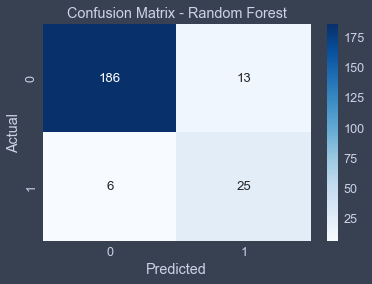

In [117]:
# Calcular a matriz de confusão para o modelo de Árvore de Decisão
cm_rf = confusion_matrix(y_test, clf.predict(X_test))

# Plotar a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()


### Guardando o Modelo

In [118]:
file_name = "model_xgboost_fraud.bin"
joblib.dump(XGBoost_model, file_name)

#pickle.dump(gbc, open(file_name, "wb"))

['model_xgboost_fraud.bin']